<a href="https://colab.research.google.com/github/Marco-178/Anomaly-Detection-Thesis/blob/main/time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import use
from sklearn import metrics
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope, LedoitWolf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import shuffle
from sklearn.manifold import TSNE
from kneed import KneeLocator
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from deepod.models.tabular import DeepIsolationForest
from deepod.models.tabular import DeepSVDD
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense, LeakyReLU, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from lof_tuner import LOF_AutoTuner
import sys
import umap

filename = ""
filepath = ""

def plot_corr_matrix(X: pd.DataFrame):
    correlation_matrix = X.corr()
    f = plt.figure(figsize=(19, 15))
    plt.matshow(correlation_matrix, fignum=f.number)
    plt.xticks(range(X.select_dtypes(['number']).shape[1]), X.select_dtypes(['number']).columns, fontsize=14, rotation=45)
    plt.yticks(range(X.select_dtypes(['number']).shape[1]), X.select_dtypes(['number']).columns, fontsize=14)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title('Correlation Matrix', fontsize=16)
    plt.savefig(f'{filepath}/corr_matrix-{filename}.png', bbox_inches='tight')
    plt.show()

class model():
    def __init__(self):
        self.name = "model"
        self.reducer_name = ""
        self.predictions = None
        self.model = None
        self.labels = None
        self.no_clusters = None
        self.reducer = None
        self.predictions_training = None

    def tsne_decompose(self, X): # https://github.com/scikit-learn/scikit-learn/issues/19717
        self.reducer = TSNE(n_components=3, perplexity=30.0, random_state=42)
        self.reducer_name = "t-SNE"
        X_tsne = self.reducer.fit_transform(X)
        return X_tsne

    def umap_decompose(self, X):
        opt_neighbors = 200 # 40 - 200
        if filename == "Dataset_Test_2000_colonne_sbilanciato_time2vec":
            opt_neighbors = 5
        elif filepath == "Dataset Time Series 180 time step":
            opt_neighbors = 10
        elif filename == "Dataset_Test_1_sbilanciato_encoder_tabular":
            opt_neighbors = 40
        print("visualizzazione umap:", opt_neighbors, "vicini")
        self.reducer = umap.UMAP(min_dist=1, n_neighbors=opt_neighbors, n_components=3, random_state=42, metric="euclidean")
        self.reducer_name = "umap"
        X_umap = self.reducer.fit_transform(X)
        X_umap.shape
        return X_umap

    def plot_clusters(self, X):
        fig = plt.figure(figsize=(12, 6))

        X_tsne = self.tsne_decompose(X)
        df = pd.DataFrame(X_tsne, columns=['Dimensione 1', 'Dimensione 2', 'Dimensione 3'])
        df['cluster'] = self.predictions
        ax1 = fig.add_subplot(121, projection='3d')
        for cluster in np.unique(self.predictions):
            ax1.scatter(df[df['cluster'] == cluster]['Dimensione 1'],
                        df[df['cluster'] == cluster]['Dimensione 2'],
                        df[df['cluster'] == cluster]['Dimensione 3'],
                        label=f'Cluster {cluster}')

        ax1.set_title(f'Visualizzazione {self.reducer_name} 3D clusters {self.name}')
        fig.canvas.manager.set_window_title(self.name)
        ax1.set_xlabel('Dimensione 1')
        ax1.set_ylabel('Dimensione 2')
        ax1.set_zlabel('Dimensione 3')
        ax1.legend()

        X_umap = self.umap_decompose(X)
        df = pd.DataFrame(X_umap, columns=['Dimensione 1', 'Dimensione 2', 'Dimensione 3'])
        df['cluster'] = self.predictions
        ax2 = fig.add_subplot(122, projection='3d')
        for cluster in np.unique(self.predictions):
            ax2.scatter(df[df['cluster'] == cluster]['Dimensione 1'],
                        df[df['cluster'] == cluster]['Dimensione 2'],
                        df[df['cluster'] == cluster]['Dimensione 3'],
                        label=f'Cluster {cluster}')

        ax2.set_title(f'Visualizzazione {self.reducer_name} 3D clusters {self.name} -\n{filename}')
        fig.canvas.manager.set_window_title(self.name)
        ax2.set_xlabel('Dimensione 1')
        ax2.set_ylabel('Dimensione 2')
        ax2.set_zlabel('Dimensione 3')
        ax2.legend()

        plt.savefig(f'{filepath}/{self.name}-plot-{filename}.png', bbox_inches='tight')
        plt.show()

    def benchmark(self, X:pd.DataFrame, y:pd.DataFrame):
        # Metriche Intrinseche
        y = y.iloc[:, 0].values
        print(f"\nModel: {self.name}")
        if self.no_clusters != None and self.no_clusters != 1: print(f"Identificati {self.no_clusters} clusters")
        unique_predictions = np.unique(self.predictions)
        clustering_metrics = []
        if len(unique_predictions) > 1:
            clustering_metrics += [
                ("Silhouette Score:", "%0.3f" % metrics.silhouette_score(X, self.predictions)),
            ]
        # Metriche Estrinseche
        precision_curve, recall_curve, _ = metrics.precision_recall_curve(y, self.predictions)
        clustering_metrics += [
            ("F1-Score:", "%0.3f" % metrics.f1_score(y, self.predictions, average='macro')),
            ("Precision:", "%0.3f" % metrics.precision_score(y, self.predictions, average='macro')),
            ("Recall:", "%0.3f" % metrics.recall_score(y, self.predictions, average='macro')),
            ("AUC PR:", "%0.3f" %  metrics.auc(recall_curve, precision_curve)),
        ]
        for i in range(len(clustering_metrics)):
            print(clustering_metrics[i][0], clustering_metrics[i][1])

    def plot_confusion_matrix(self, X_test, y_test):
        cm = confusion_matrix(y_test, self.predictions)

        disp = ConfusionMatrixDisplay(confusion_matrix=cm).plot()
        plt.title(f"Confusion Matrix - {self.name} - {filename}")
        plt.savefig(f'{filepath}/{self.name}-confusion_matrix-{filename}.png', bbox_inches='tight')
        plt.show()

class dbscan_model(model):
    def __init__(self):
        super().__init__()
        self.name = "dbscan"
        self.knee = None
        self.epsilon_knee = None
        self.labels_single_cluster = None
        self.min_samples = 20
        self.no_noise = 0

    def set_min_samples(self, min_samples):
        self.min_samples = min_samples

    def estimateEpsilon(self, X):
        nearest_neighbors = NearestNeighbors(n_neighbors=self.min_samples+1) # self.min_samples +1 è solo un test
        neighbors = nearest_neighbors.fit(X)

        candidates_epsilon, indices = neighbors.kneighbors(X)
        candidates_epsilon = np.sort(candidates_epsilon[:,10], axis=0)

        i = np.arange(len(candidates_epsilon))
        self.knee = KneeLocator(i, candidates_epsilon, S=1, curve='convex', direction='increasing', interp_method='polynomial')
        self.epsilon_knee = candidates_epsilon[self.knee.knee]
        print("distanza stimata per ottimizzare il clustering:", "%0.3f" % self.epsilon_knee)

    def plot_knee(self):
        self.knee.plot_knee()
        plt.xlabel("Points")
        plt.ylabel("Distance")
        plt.savefig(f'{filepath}/knee-{filename}.png', bbox_inches='tight')
        plt.show()

    def apply_model(self, X_train, X_test):
        self.model = DBSCAN(eps=self.epsilon_knee, min_samples=self.min_samples).fit(X_train)
        self.labels = self.model.labels_
        unique_labels, counts = np.unique(self.labels, return_counts=True)

        mask = unique_labels != -1
        valid_labels = unique_labels[mask]
        valid_counts = counts[mask]

        if valid_labels.size == 0:
            print("Nessun cluster valido trovato. Tutti i punti sono considerati rumore.")
            raise RuntimeError("Nessun cluster valido trovato.")

        largest_cluster_label = valid_labels[np.argmax(valid_counts)]
        labels_single_cluster = self.labels.copy()
        labels_single_cluster[self.labels != -1] = largest_cluster_label
        labels_single_cluster[self.labels != -1] = 0
        labels_single_cluster[self.labels == -1] = 1
        self.predictions_training = labels_single_cluster.copy()

        self.model = DBSCAN(eps=self.epsilon_knee, min_samples=self.min_samples).fit(X_test)
        self.labels = self.model.labels_
        unique_labels, counts = np.unique(self.labels, return_counts=True)

        mask = unique_labels != -1
        valid_labels = unique_labels[mask]
        valid_counts = counts[mask]

        if valid_labels.size == 0:
            print("Nessun cluster valido trovato. Tutti i punti sono considerati rumore.")
            raise RuntimeError("Nessun cluster valido trovato.")

        largest_cluster_label = valid_labels[np.argmax(valid_counts)]
        labels_single_cluster = self.labels.copy()
        labels_single_cluster[self.labels != -1] = largest_cluster_label
        labels_single_cluster[self.labels != -1] = 0
        labels_single_cluster[self.labels == -1] = 1
        self.predictions = labels_single_cluster.copy()

        self.no_clusters = len(np.unique(labels_single_cluster))
        self.no_noise = np.sum(labels_single_cluster == 1)

class IsolationForest_model(model):
    def __init__(self, contamination=0.1, n_estimators=200, max_features=1.0, bootstrap=True):
        super().__init__()
        self.name = "Isolation Forest"
        self.no_clusters = 2
        self.no_noise = None
        self.scores = 0

        self.contamination = contamination
        self.n_estimators = n_estimators
        self.max_features = max_features
        self.bootstrap = bootstrap

    def apply_model(self, X_train, X_test):
        self.fit(X_train)
        self.predictions_training, training_scores, training_labels = self.predict(X_train)
        self.predictions, _, _ = self.predict(X_test)
        return self.predictions_training, training_scores, training_labels

    def fit(self, X):
        self.model = IsolationForest(
            contamination=self.contamination,
            random_state=42,
            n_estimators=self.n_estimators,
            max_features=self.max_features,
            bootstrap=self.bootstrap
        )
        self.model.fit(X)

    def predict(self, X):
        self.scores = self.model.decision_function(X)
        self.labels = self.model.predict(X)
        self.predictions = np.where(self.labels == -1, 1, 0)

        self.no_noise = np.sum(self.predictions == 1)
        print(f'Stimati noise points: {self.no_noise}')
        return self.predictions, self.scores, self.labels


class OneClassSVM_model(model):
    def __init__(self, kernel='rbf', gamma='scale', nu=0.1):
        super().__init__()
        self.name = "OneClassSVM"
        self.no_noise = None
        self.kernel = kernel
        self.gamma = gamma
        self.nu = nu

    def apply_model(self, X_train, X_test):
        self.predictions_training, training_labels = self.fit(X_train)
        self.predictions, _ = self.predict(X_test)
        return self.predictions_training, training_labels

    def fit(self, X):
        self.model = OneClassSVM(kernel=self.kernel, gamma=self.gamma, nu=self.nu)
        training_labels = self.model.fit_predict(X)
        self.predictions_training = training_labels
        return self.predictions_training, training_labels

    def predict(self, X):
        self.labels = self.model.predict(X)
        self.predictions = np.where(self.labels == -1, 1, 0)

        self.no_noise = np.sum(self.predictions == 1)
        print(f'Stimati noise points: {self.no_noise}')
        return self.predictions, self.labels


class LocalOutlierFactor_model(model):
    def __init__(self, no_neighbors = 4, contamination = 0.1):
        super().__init__()
        self.name = "Local Outlier Factor"
        self.no_clusters = 2
        self.no_noise = None
        self.Kopt = None
        self.Copt = None

        self.no_neighbors = no_neighbors
        self.contamination = contamination

    def estimate_neighbors_and_contamination(self, X):
        tuner = LOF_AutoTuner(data=X, k_max=100, c_max=0.1)
        tuner.run() # k=4 c=0.1
        self.Kopt = tuner.tuned_params['k']
        self.Copt = tuner.tuned_params['c']

    def apply_model(self, X_train, X_test):
        self.fit(X_train)
        self.predictions_training, training_labels = self.predict(X_train)
        self.predictions, _ = self.predict(X_test)
        return self.predictions_training, training_labels

    def fit(self, X):
        if(self.Kopt is not None):
            self.no_neighbors = self.Kopt
        if(self.Copt is not None):
            self.contamination = self.Copt
        self.model = LocalOutlierFactor(n_neighbors=self.no_neighbors, contamination=self.contamination, novelty=True) # n_neighbors=20, contamination=0.15)
        self.model.fit(X)

    def predict(self, X):
        self.labels = self.model.predict(X)
        self.predictions = np.where(self.labels == 1, 0, 1)

        self.no_noise = np.sum(self.labels == 1)
        print(f'Stimati noise points: {self.no_noise}')
        return self.predictions, self.labels

class DeepIsolationForest_model(model):
    def __init__(self):
        super().__init__()
        self.name = "Deep Isolation Forest"
        self.no_clusters = 2
        self.no_noise = None

    def apply_model(self, X_train, X_test):
        self.model = DeepIsolationForest()
        self.model.fit(X_train)
        training_labels = self.model.predict(X_train)
        self.predictions_training = training_labels
        self.predictions = self.model.predict(X_test) # già label corrette: 0 cluster e 1 outliers
        print(f'Stimati noise points: {self.no_noise}')
        return self.predictions_training, training_labels

class DeepSVDD_model(model):
    def __init__(self, rep_dim=128, epochs=100):
        super().__init__()
        self.name = "Deep SVDD"
        self.no_clusters = 2
        self.no_noise = None
        self.scores = 0
        self.rep_dim = rep_dim
        self.epochs = epochs
        self.model = DeepSVDD(rep_dim=self.rep_dim, epochs=self.epochs, random_state=42, device='cpu')

    def apply_model(self, X_train, X_test):
        self.model.fit(X_train)
        training_labels = self.predict(X_train)
        self.predictions_training = training_labels
        self.predictions = self.predict(X_test)
        return self.predictions_training, training_labels

    def predict(self, X):
        self.scores = self.model.decision_function(X)
        self.labels = self.model.predict(X)
        self.predictions = np.where(self.labels == 1, 0, 1)
        self.no_noise = np.sum(self.predictions == 1)
        print(f'Stimati noise points: {self.no_noise}')
        return self.predictions

class EllipticEnvelope_model(model):
    def __init__(self, contamination=0.01, random_state=42):
        super().__init__()
        self.name = "Elliptic Envelope"
        self.contamination = contamination
        self.random_state = random_state
        self.cov_estimator = LedoitWolf()
        self.no_noise = 0

    def apply_model(self, X_train, X_test):
        self.fit(X_train)
        training_labels = self.predict(X_train)
        self.predictions_training = training_labels
        self.predictions = self.predict(X_test)
        return self.predictions_training, training_labels

    def fit(self, X):
        self.cov_estimator.fit(X)
        covariance_ = self.cov_estimator.covariance_
        self.model = EllipticEnvelope(contamination=self.contamination, random_state=self.random_state, support_fraction=None)
        # calcolo manuale della matrice di covarianza con LedoitWolf() per renderla invertibile
        self.model.covariance_ = covariance_
        self.model.location_ = np.mean(X, axis=0)
        self.model.precision_ = np.linalg.inv(covariance_)
        mahal_dist = np.sum((X - self.model.location_) @ self.model.precision_ * (X - self.model.location_), axis=1) # calcolo manuale distanza di Mahalanobis
        self.model.offset_ = np.percentile(mahal_dist, 100 * (1 - self.contamination))
        self.model.fitted_ = True

    def predict(self, X):
        self.labels = self.model.predict(X)
        self.predictions = np.where(self.labels == 1, 0, 1)
        self.no_noise = np.sum(self.predictions == 1)
        print(f'Stimati noise points: {self.no_noise}')
        return self.predictions

class AnoGAN_model(model):
    def __init__(self, input_dim, latent_dim=10, epochs=600, batch_size=512, cpu_threads=8):
        self.name = "AnoGAN"
        self.no_clusters = 2
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.epochs = epochs
        self.batch_size = batch_size

        if cpu_threads is not None:
            tf.config.threading.set_intra_op_parallelism_threads(cpu_threads)
            tf.config.threading.set_inter_op_parallelism_threads(cpu_threads)

        self.generator = self.build_generator()
        self.discriminator = self.build_discriminator()
        self.gan = self.build_gan()

        self.class_weights = {0: 1.0, 1: 50.0}

    def build_discriminator(self):
        model = Sequential()
        model.add(Dense(256, input_dim=self.input_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.3))

        model.add(Dense(128))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.3))

        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.002))
        return model

    def build_generator(self):
        model = Sequential()
        model.add(Dense(64, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.3))

        model.add(Dense(self.input_dim, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002))
        return model

    def build_gan(self):
        model = Sequential()
        model.add(self.generator)
        model.add(self.discriminator)
        model.compile(loss='binary_crossentropy', optimizer=Adam())
        return model

    def train(self, X_train):
        for epoch in range(self.epochs):
            noise = np.random.normal(0, 1, (self.batch_size, self.latent_dim))
            generated_data = self.generator.predict(noise, verbose=0)
            real_data = X_train[np.random.randint(0, X_train.shape[0], self.batch_size)]

            X_combined_batch = np.concatenate([real_data, generated_data])
            y_combined_batch = np.concatenate([
                np.random.uniform(0.0, 0.1, (self.batch_size, 1)), # label-smoothing delle etichette
                np.random.uniform(0.9, 1.0, (self.batch_size, 1))
            ])

            X_combined_batch_shuffled, y_combined_batch_shuffled = shuffle(X_combined_batch, y_combined_batch, random_state=42)

            d_loss = self.discriminator.train_on_batch(X_combined_batch_shuffled, y_combined_batch_shuffled, class_weight=self.class_weights)

            noise = np.random.normal(0, 1, (self.batch_size, self.latent_dim))
            y_target_for_generator = np.zeros((self.batch_size, 1))
            g_loss = self.gan.train_on_batch(noise, y_target_for_generator)

            if epoch % 100 == 0:
                print(f'Epoch {epoch} | Discriminator Loss: {d_loss} | Generator Loss: {g_loss}')

    def predict(self, X_test, threshold=0.5):
        predictions = self.discriminator.predict(X_test)
        return (predictions > threshold).astype(int).flatten()

    def apply_model(self, X_train, X_test):
        tf.random.set_seed(42)
        self.train(X_train)

        self.predictions = self.predict(X_test, threshold=0.3)

        training_labels = np.ones(X_train.shape[0])
        return self.predictions, training_labels

def main():
    global filepath
    global filename
    if len(sys.argv) > 1:
        filepath = sys.argv[1]
        filename_train = sys.argv[2]
        filename = sys.argv[3]
        num_components = int(sys.argv[4])
        dataset_csv_test = f"{filepath}/Noise/{filename}.csv"
        dataset_csv_train = f"{filepath}/Training e Test/{filename_train}.csv"
        print("Dati ricevuti: ", filepath, filename_train, filename, num_components)
        print("File di test: ", dataset_csv_test)
        use('Agg')
    else:
        filepath = "Dataset Time Series 180 time step flatten"
        filename = "Dataset_Test_2_sbilanciato_encoder_tabular"
        # metto qui queste variabili globali solo per comodità
        dataset_csv_test = f"{filepath}/Noise/{filename}.csv"
        dataset_csv_train = f"{filepath}/Training e Test/Dataset_Train_sbilanciato_180_time_steps_encoder_tabular.csv"
        num_components=1800
    # plt.style.use('dark_background')
    X_train = pd.read_csv(dataset_csv_train)
    df_test = pd.read_csv(dataset_csv_test)

    X_test = df_test[df_test.columns[:num_components]]
    y_test = df_test[[df_test.columns[num_components]]]

    scale = StandardScaler()
    X_train = scale.fit_transform(X_train.values)
    X_test = scale.transform(X_test.values)

    real_data = model()
    real_data.predictions = y_test
    real_data.plot_clusters(X_test)

    # clustering
    db = dbscan_model()
    db.estimateEpsilon(X_train)
    db.plot_knee()
    db.apply_model(X_train, X_test)
    db.benchmark(X_test, y_test)
    db.plot_confusion_matrix(X_test, y_test)
    db.plot_clusters(X_test)

    # anomaly detection: Isolation forest, One-Class SVM, Local Outlier Factor, DeepOD
    iso_forest = IsolationForest_model()
    _, _, _ = iso_forest.apply_model(X_train, X_test)
    iso_forest.benchmark(X_test, y_test)
    iso_forest.plot_confusion_matrix(X_test, y_test)
    iso_forest.plot_clusters(X_test)

    ocsvm = OneClassSVM_model()
    _, _ = ocsvm.apply_model(X_train, X_test)
    ocsvm.benchmark(X_test, y_test)
    ocsvm.plot_confusion_matrix(X_test, y_test)
    ocsvm.plot_clusters(X_test)

    lof = LocalOutlierFactor_model()
    _, _ = lof.apply_model(X_train, X_test)
    lof.benchmark(X_test, y_test)
    lof.plot_confusion_matrix(X_test, y_test)
    lof.plot_clusters(X_test)

    deepIF = DeepIsolationForest_model()
    _, _ = deepIF.apply_model(X_train, X_test)
    deepIF.benchmark(X_test, y_test)
    deepIF.plot_confusion_matrix(X_test, y_test)
    deepIF.plot_clusters(X_test)

    deepSVDD = DeepSVDD_model()
    _, _ = deepSVDD.apply_model(X_train, X_test)
    deepSVDD.benchmark(X_test, y_test)
    deepSVDD.plot_confusion_matrix(X_test, y_test)
    deepSVDD.plot_clusters(X_test)

    EllEnv = EllipticEnvelope_model()
    _, _ = EllEnv.apply_model(X_train, X_test)
    EllEnv.benchmark(X_test, y_test)
    EllEnv.plot_confusion_matrix(X_test, y_test)
    EllEnv.plot_clusters(X_test)

    print('\nAnoGAN Training')
    anogan_model = AnoGAN_model(input_dim=num_components)
    anomaly_predictions, training_labels = anogan_model.apply_model(X_train, X_test) # modal collapse?
    anogan_model.benchmark(X_test, y_test)
    anogan_model.plot_confusion_matrix(X_test, y_test)
    anogan_model.plot_clusters(X_test)

if __name__ == "__main__":
    main()

ModuleNotFoundError: No module named 'datashader'

# **Dataset Test 1 Sbilanciato**


In [ ]:
Varianza totale dei dati originali: 1800.0
distanza stimata per ottimizzare il clustering: 26.631

Model: dbscan
Identificati 2 clusters
Silhouette Score: 0.171
F1-Score 0.569
Precision 0.880
Recall 0.521
Stimati noise points: 225
Stimati noise points: 26

Model: Isolation Forest
Identificati 2 clusters
Silhouette Score: 0.206
F1-Score 0.881
Precision 0.896
Recall 0.874
Stimati noise points: 27

Model: OneClassSVM
Silhouette Score: 0.204
F1-Score 0.937
Precision 0.953
Recall 0.933
Stimati noise points: 2098
Stimati noise points: 89

Model: Local Outlier Factor
Identificati 2 clusters
Silhouette Score: 0.157
F1-Score 0.915
Precision 0.941
Recall 0.908
Start Training...
Start Inference on the training data...
Start Inference...
Start Inference...
Start Inference...
Stimati noise points: None

Model: Deep Isolation Forest
Identificati 2 clusters
Silhouette Score: 0.302
F1-Score 0.975
Precision 0.974
Recall 0.975
Start Training...
ensemble size: 1
MLPnet(
  (network): Sequential(
    (0): LinearBlock(
      (linear): Linear(in_features=2160, out_features=100, bias=False)
      (act_layer): ReLU()
    )
    (1): LinearBlock(
      (linear): Linear(in_features=100, out_features=50, bias=False)
      (act_layer): ReLU()
    )
    (2): LinearBlock(
      (linear): Linear(in_features=50, out_features=128, bias=False)
      (act_layer): Identity()
    )
  )
)
epoch  1, training loss: 0.494422, time: 0.8s
epoch 10, training loss: 0.004903, time: 0.3s
epoch 20, training loss: 0.001776, time: 0.3s
epoch 30, training loss: 0.001197, time: 0.3s
epoch 40, training loss: 0.000616, time: 0.5s
epoch 50, training loss: 0.000600, time: 0.4s
epoch 60, training loss: 0.001303, time: 0.4s
epoch 70, training loss: 0.000489, time: 0.4s
epoch 80, training loss: 0.000264, time: 0.4s
epoch 90, training loss: 0.000673, time: 0.4s
epoch100, training loss: 0.001139, time: 0.4s
Start Inference on the training data...
Stimati noise points: 2024
Stimati noise points: 66

Model: Deep SVDD
Identificati 2 clusters
Silhouette Score: 0.104
F1-Score 0.373
Precision 0.539
Recall 0.286
Stimati noise points: 2249
Stimati noise points: 119

Model: Elliptic Envelope
F1-Score 0.044
Precision 0.025
Recall 0.160

AnoGAN Training
Epoch 0 | Discriminator Loss: 17.155521392822266 | Generator Loss: 16.44878387451172
Epoch 100 | Discriminator Loss: 7.4642438888549805 | Generator Loss: 6.310605049133301
Epoch 200 | Discriminator Loss: 6.858816623687744 | Generator Loss: 3.5181124210357666
Epoch 300 | Discriminator Loss: 6.4829559326171875 | Generator Loss: 5.252674102783203
Epoch 400 | Discriminator Loss: 5.740964889526367 | Generator Loss: 4.536303520202637
Epoch 500 | Discriminator Loss: 6.308267116546631 | Generator Loss: 4.439113616943359

Model: AnoGAN (Anomaly Detection with Generative Adversarial Networks)
Identificati 2 clusters
Silhouette Score: 0.612
F1-Score: 0.967
Precision: 0.990
Recall: 0.947
AUC PR: 0.956

**Plot etichette reali**

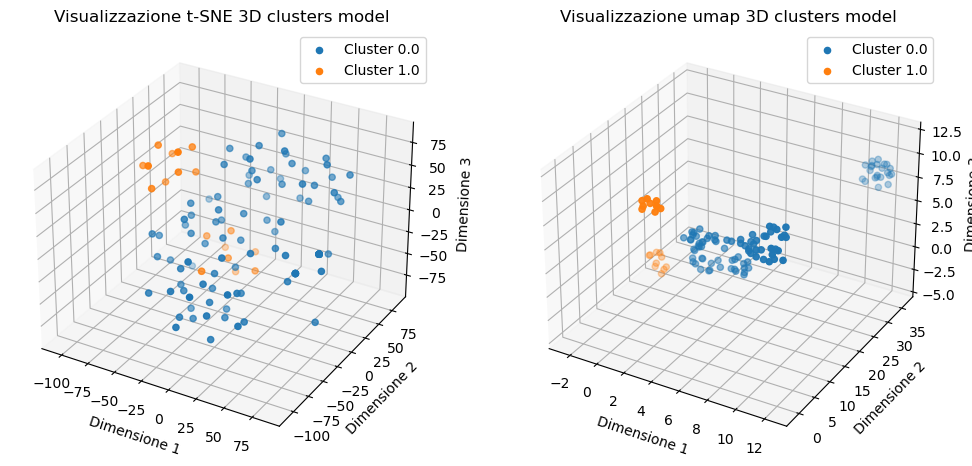

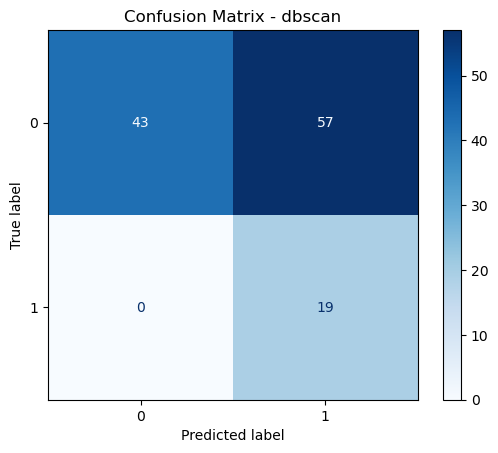

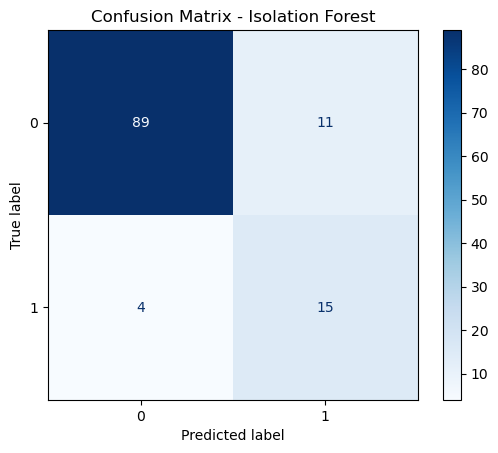

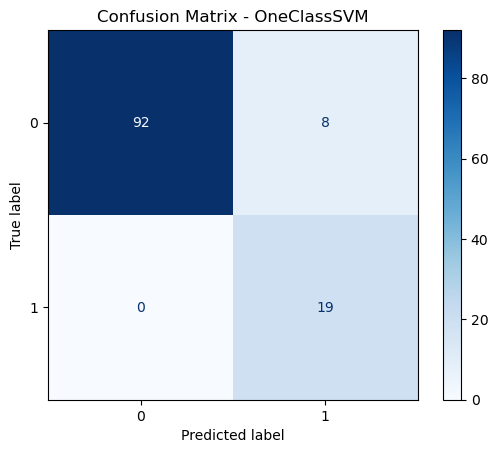

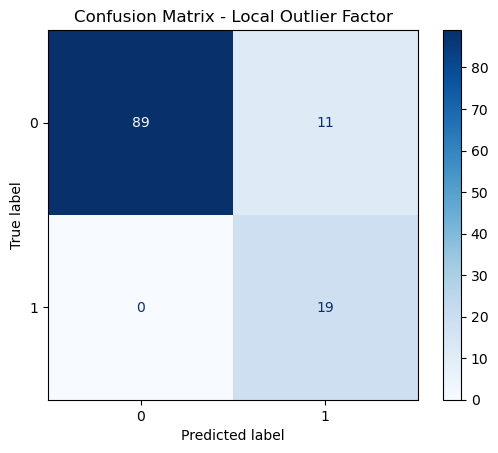

ì

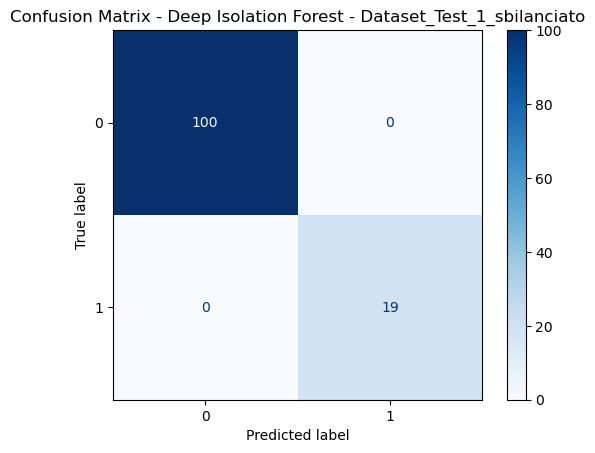

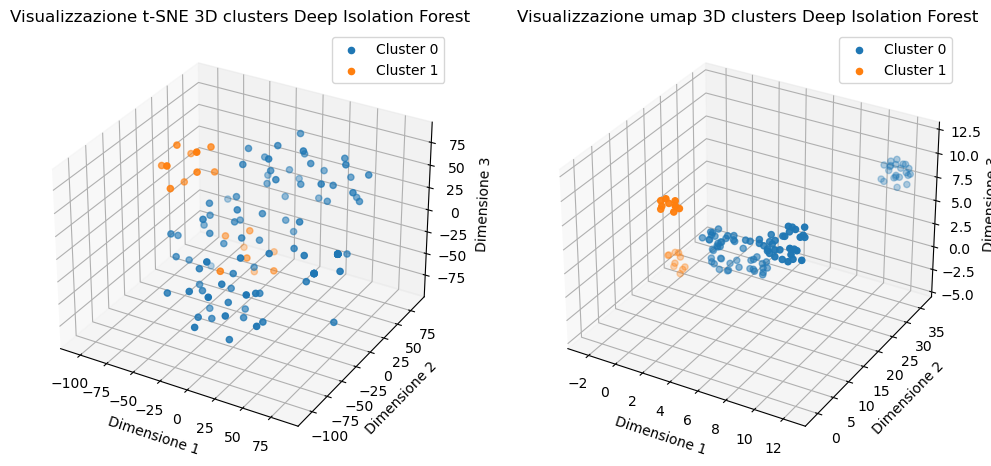

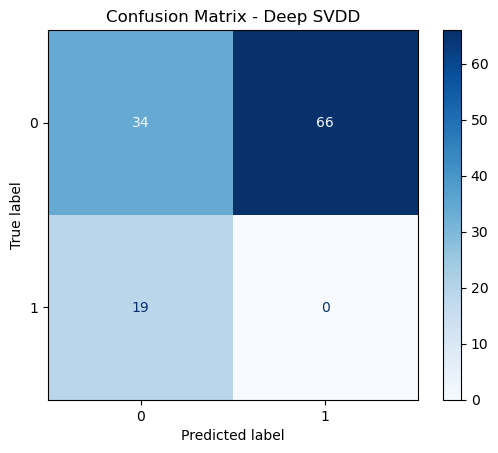


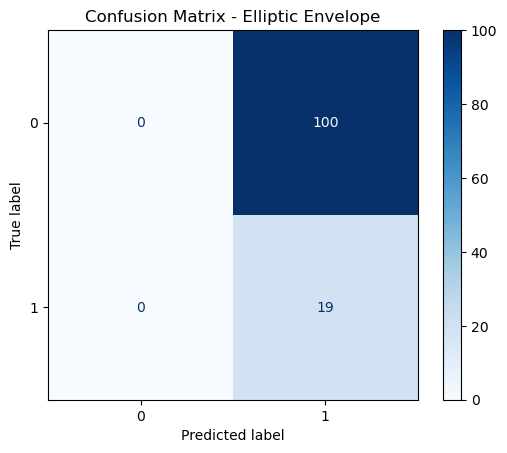

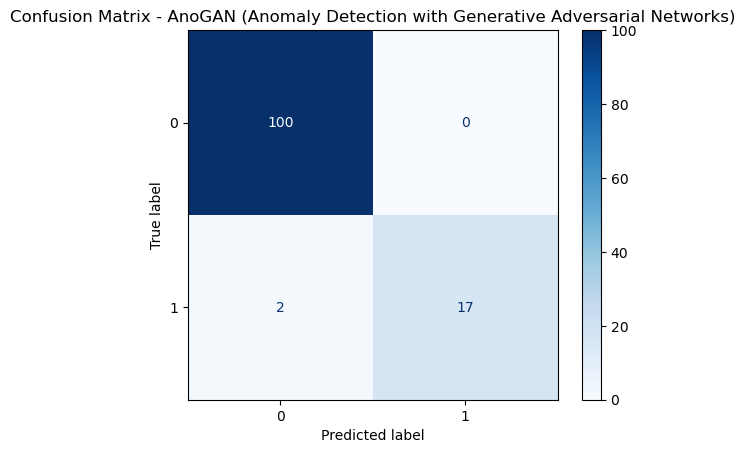

# **Dataset Test 2 Sbilanciato**

In [ ]:
Varianza totale dei dati originali: 1800.0
distanza stimata per ottimizzare il clustering: 26.631

Model: dbscan
Identificati 2 clusters
Silhouette Score: 0.171
F1-Score 0.569
Precision 0.880
Recall 0.521
Stimati noise points: 225
Stimati noise points: 26

Model: Isolation Forest
Identificati 2 clusters
Silhouette Score: 0.206
F1-Score 0.881
Precision 0.896
Recall 0.874
Stimati noise points: 27

Model: OneClassSVM
Silhouette Score: 0.204
F1-Score 0.937
Precision 0.953
Recall 0.933
Stimati noise points: 2098
Stimati noise points: 89

Model: Local Outlier Factor
Identificati 2 clusters
Silhouette Score: 0.157
F1-Score 0.915
Precision 0.941
Recall 0.908
Start Training...
Start Inference on the training data...
Start Inference...
Start Inference...
Start Inference...
Stimati noise points: None

Model: Deep Isolation Forest
Identificati 2 clusters
Silhouette Score: 0.302
F1-Score 0.975
Precision 0.974
Recall 0.975
Start Training...
ensemble size: 1
MLPnet(
  (network): Sequential(
    (0): LinearBlock(
      (linear): Linear(in_features=2160, out_features=100, bias=False)
      (act_layer): ReLU()
    )
    (1): LinearBlock(
      (linear): Linear(in_features=100, out_features=50, bias=False)
      (act_layer): ReLU()
    )
    (2): LinearBlock(
      (linear): Linear(in_features=50, out_features=128, bias=False)
      (act_layer): Identity()
    )
  )
)
epoch  1, training loss: 0.494422, time: 0.7s
epoch 10, training loss: 0.004903, time: 0.5s
epoch 20, training loss: 0.001776, time: 0.7s
epoch 30, training loss: 0.001197, time: 0.5s
epoch 40, training loss: 0.000616, time: 0.5s
epoch 50, training loss: 0.000600, time: 0.4s
epoch 60, training loss: 0.001303, time: 0.4s
epoch 70, training loss: 0.000489, time: 0.4s
epoch 80, training loss: 0.000264, time: 0.4s
epoch 90, training loss: 0.000673, time: 0.4s
epoch100, training loss: 0.001139, time: 0.4s
Start Inference on the training data...
Stimati noise points: 2024
Stimati noise points: 66

Model: Deep SVDD
Identificati 2 clusters
Silhouette Score: 0.104
F1-Score 0.373
Precision 0.539
Recall 0.286
Stimati noise points: 2249
Stimati noise points: 119

Model: Elliptic Envelope
F1-Score 0.044
Precision 0.025
Recall 0.160

AnoGAN Training
Epoch 0 | Discriminator Loss: 9.342249870300293 | Generator Loss: 21.225488662719727
Epoch 100 | Discriminator Loss: 6.456092834472656 | Generator Loss: 5.415950775146484
Epoch 200 | Discriminator Loss: 6.2371439933776855 | Generator Loss: 3.355762004852295
Epoch 300 | Discriminator Loss: 5.800442695617676 | Generator Loss: 5.032337665557861
Epoch 400 | Discriminator Loss: 5.672255516052246 | Generator Loss: 4.991321563720703
Epoch 500 | Discriminator Loss: 5.59213924407959 | Generator Loss: 4.96673059463501

Model: AnoGAN (Anomaly Detection with Generative Adversarial Networks)
Identificati 2 clusters
Silhouette Score: 0.366
F1-Score: 0.912
Precision: 0.976
Recall: 0.868
AUC PR: 0.889


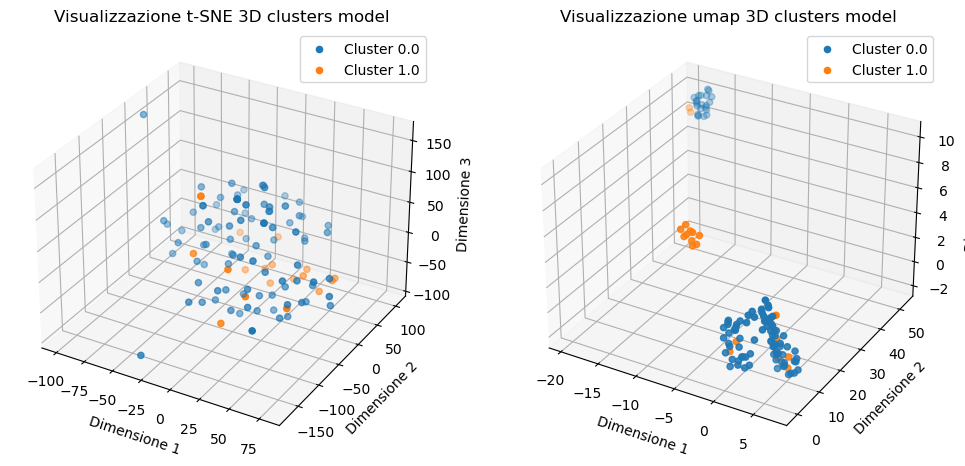

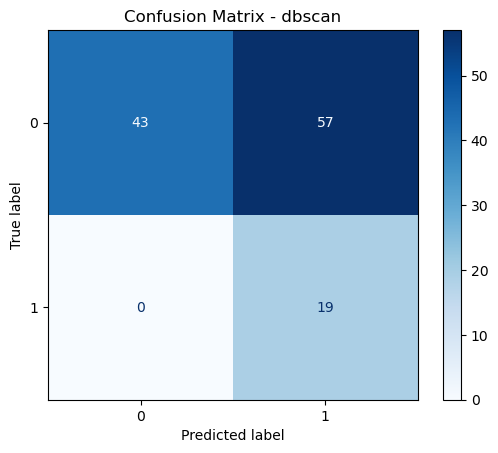

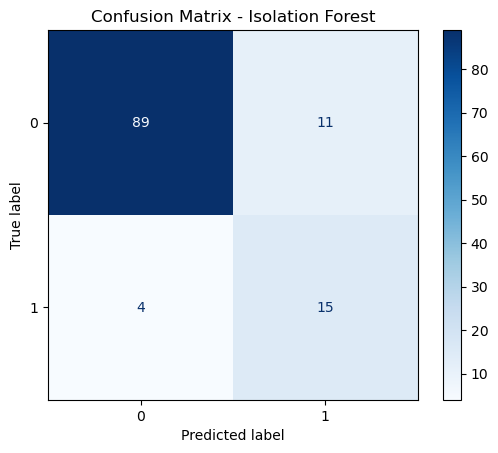

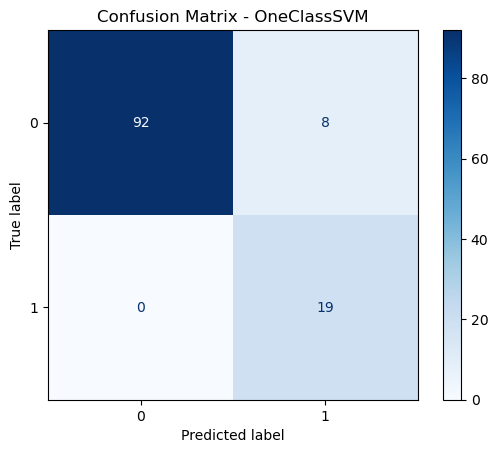

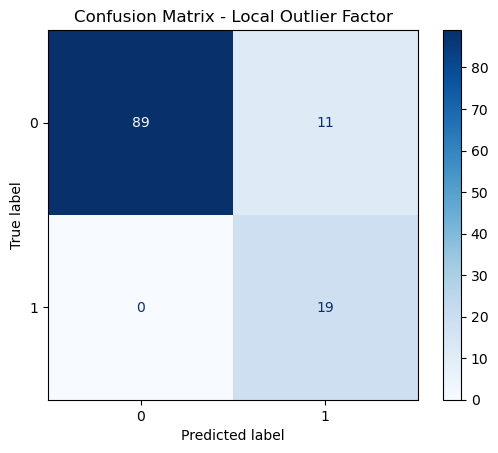

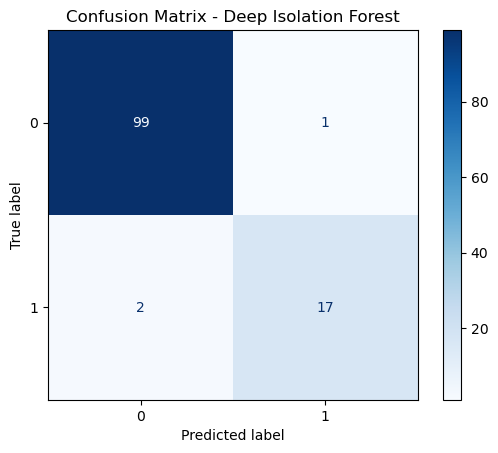

---



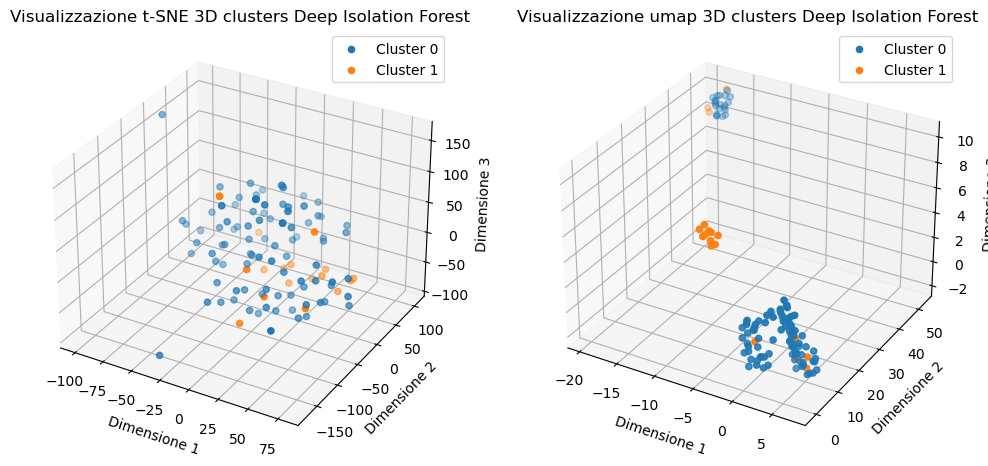

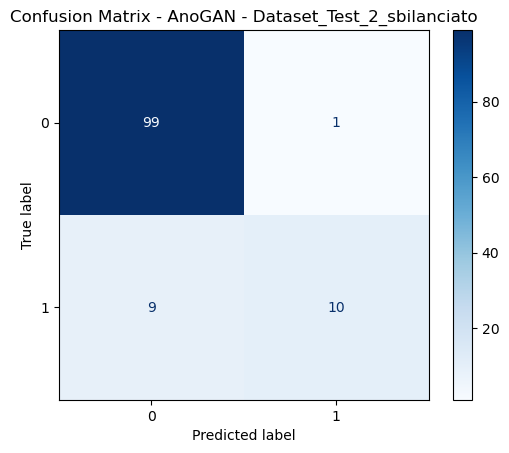

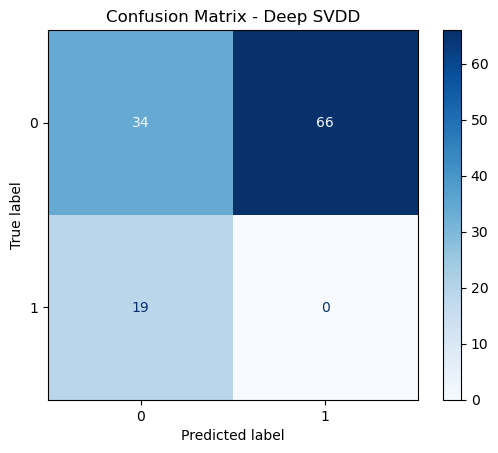

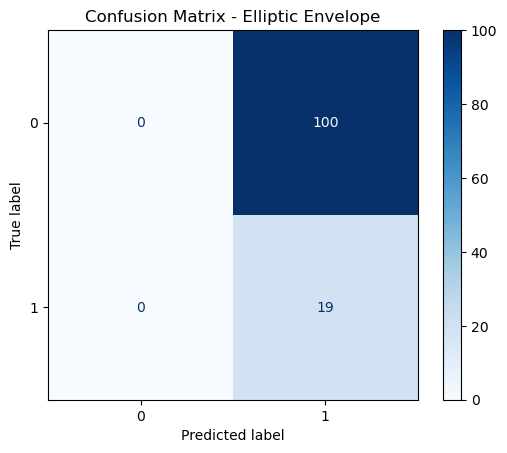

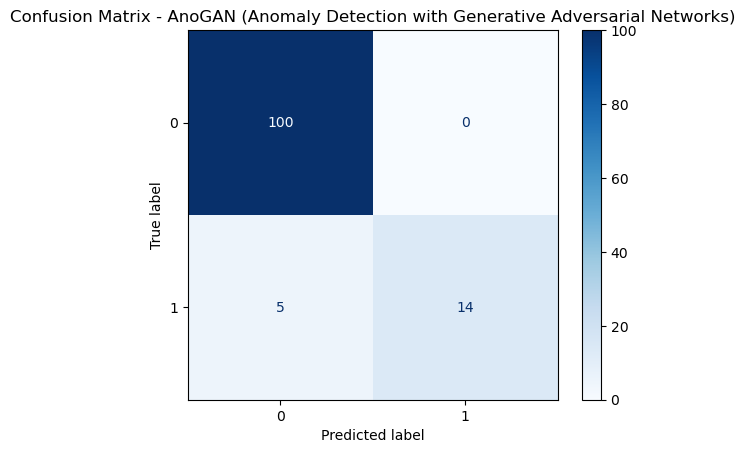

# **Dataset Test 200 colonne sbilanciato only noise time2vec**

In [ ]:
Varianza totale dei dati originali: 1800.0
distanza stimata per ottimizzare il clustering: 32.097

Model: dbscan
Identificati 2 clusters
Silhouette Score: 0.157
F1-Score 0.704
Precision 0.918
Recall 0.636
Stimati noise points: 259
Stimati noise points: 102

Model: Isolation Forest
Identificati 2 clusters
Silhouette Score: 0.185
F1-Score 0.902
Precision 0.917
Recall 0.894
Stimati noise points: 187

Model: OneClassSVM
Silhouette Score: 0.186
F1-Score 0.847
Precision 0.930
Recall 0.815
Stimati noise points: 2434
Stimati noise points: 531

Model: Local Outlier Factor
Identificati 2 clusters
Silhouette Score: 0.153
F1-Score 0.920
Precision 0.943
Recall 0.910
Start Training...
Start Inference on the training data...
Start Inference...
Start Inference...
Start Inference...
Stimati noise points: None

Model: Deep Isolation Forest
Identificati 2 clusters
Silhouette Score: 0.234
F1-Score 0.962
Precision 0.966
Recall 0.960
Start Training...
ensemble size: 1
MLPnet(
  (network): Sequential(
    (0): LinearBlock(
      (linear): Linear(in_features=2000, out_features=100, bias=False)
      (act_layer): ReLU()
    )
    (1): LinearBlock(
      (linear): Linear(in_features=100, out_features=50, bias=False)
      (act_layer): ReLU()
    )
    (2): LinearBlock(
      (linear): Linear(in_features=50, out_features=128, bias=False)
      (act_layer): Identity()
    )
  )
)
epoch  1, training loss: 0.498920, time: 0.6s
epoch 10, training loss: 0.002975, time: 0.4s
epoch 20, training loss: 0.001349, time: 0.5s
epoch 30, training loss: 0.001113, time: 0.4s
epoch 40, training loss: 0.001543, time: 0.5s
epoch 50, training loss: 0.000658, time: 0.5s
epoch 60, training loss: 0.000639, time: 0.5s
epoch 70, training loss: 0.000696, time: 0.4s
epoch 80, training loss: 0.000514, time: 0.5s
epoch 90, training loss: 0.000422, time: 0.4s
epoch100, training loss: 0.000566, time: 0.5s
Start Inference on the training data...
Stimati noise points: 2331
Stimati noise points: 400

Model: Deep SVDD
Identificati 2 clusters
Silhouette Score: 0.087
F1-Score 0.387
Precision 0.645
Recall 0.276
Stimati noise points: 2590
Stimati noise points: 648

Model: Elliptic Envelope
F1-Score 0.020
Precision 0.011
Recall 0.106

AnoGAN Training
Epoch 0 | Discriminator Loss: 15.76352310180664 | Generator Loss: 17.264022827148438
Epoch 100 | Discriminator Loss: 7.508974552154541 | Generator Loss: 5.884278297424316
Epoch 200 | Discriminator Loss: 6.6890130043029785 | Generator Loss: 3.067793846130371
Epoch 300 | Discriminator Loss: 6.5363569259643555 | Generator Loss: 4.736777305603027
Epoch 400 | Discriminator Loss: 6.62689733505249 | Generator Loss: 5.269374847412109
Epoch 500 | Discriminator Loss: 6.2217631340026855 | Generator Loss: 4.403983116149902

Model: AnoGAN (Anomaly Detection with Generative Adversarial Networks)
Identificati 2 clusters
Silhouette Score: 0.004
F1-Score: 0.471
Precision: 0.447
Recall: 0.497
AUC PR: 0.053


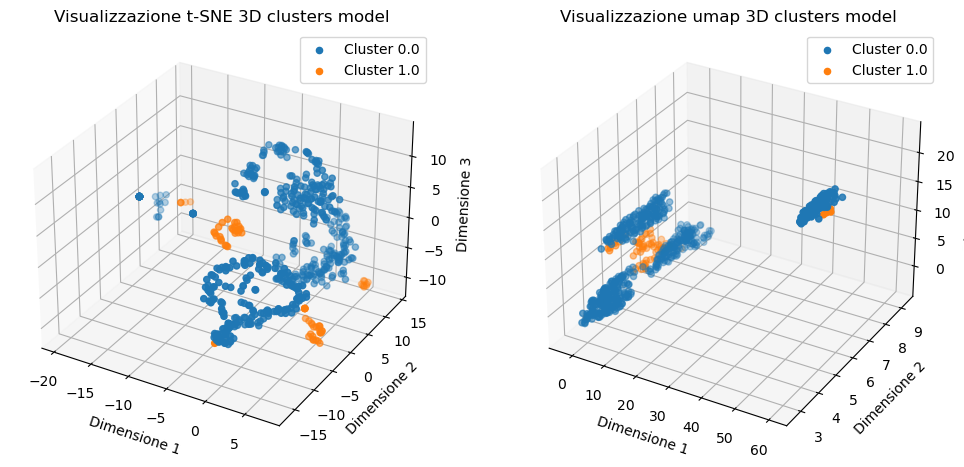

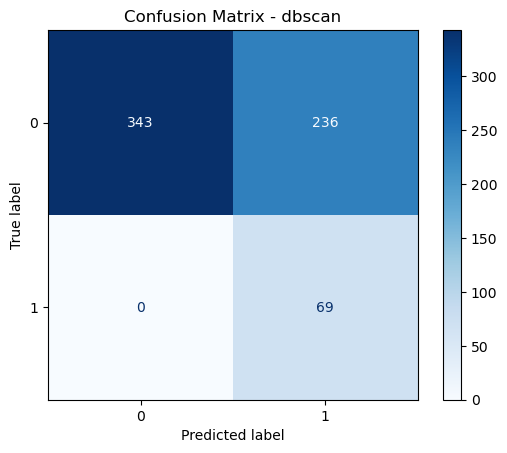

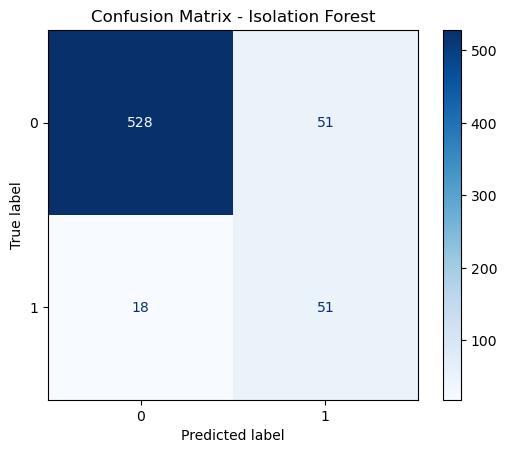

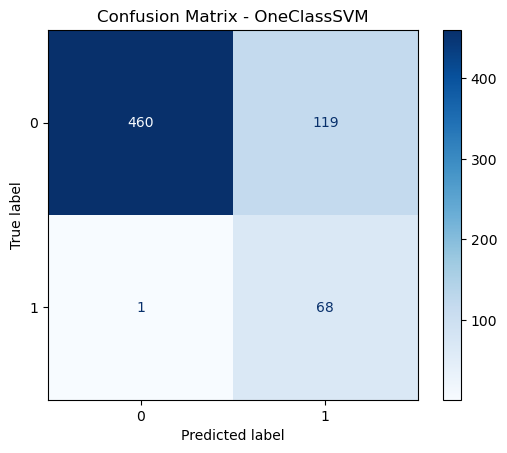

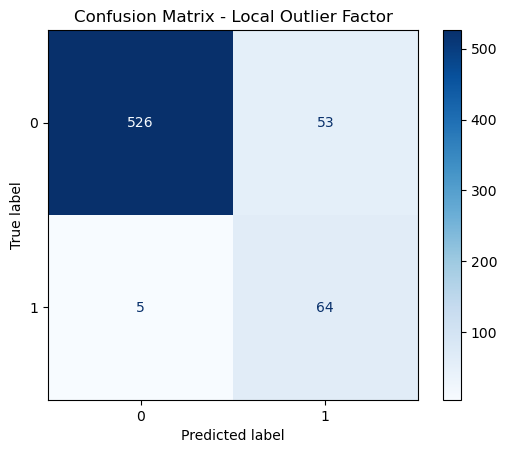

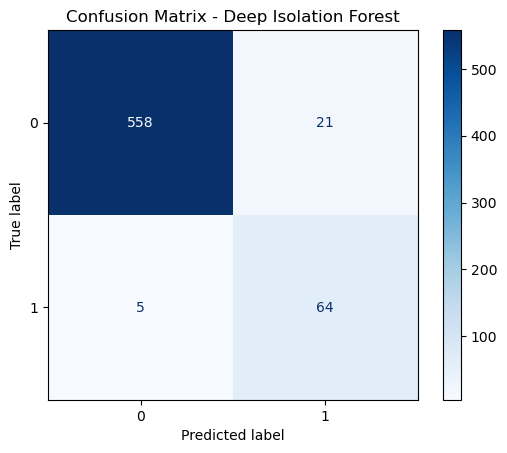

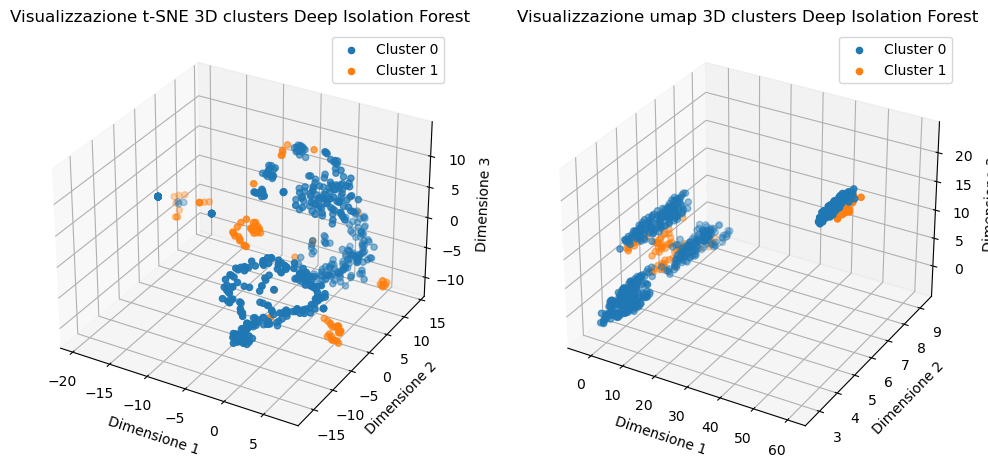

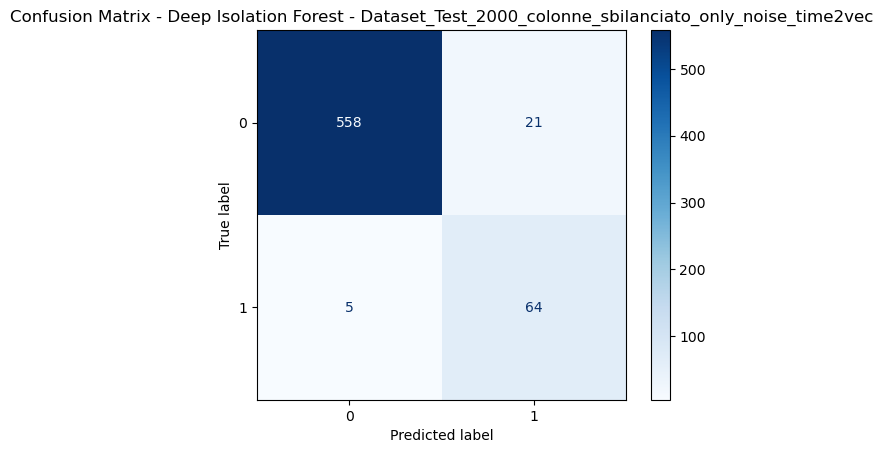

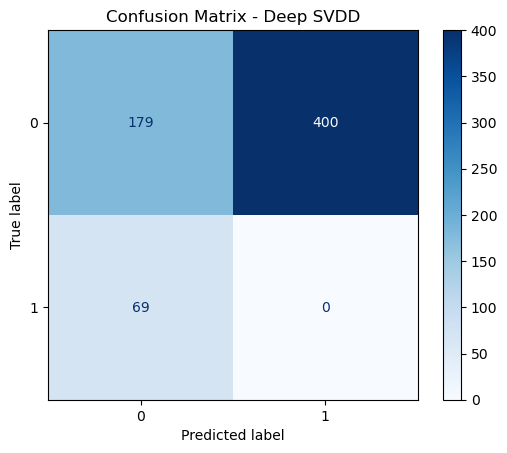

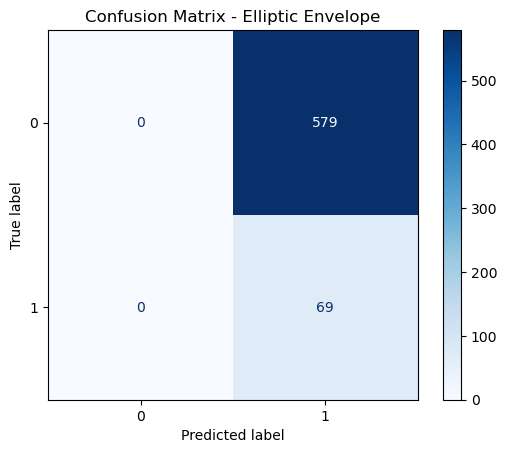

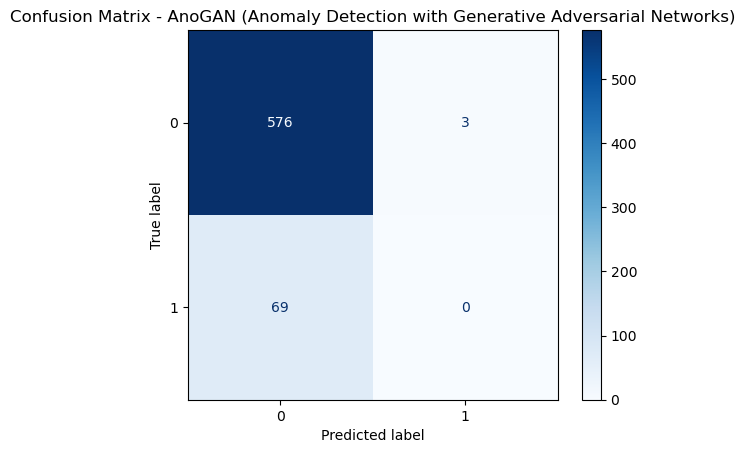

# **Dataset_Test_2000_colonne_sbilanciato_time2vec**



In [ ]:
Varianza totale dei dati originali: 1800.0
distanza stimata per ottimizzare il clustering: 32.097

Model: dbscan
Identificati 2 clusters
Silhouette Score: 0.157
F1-Score 0.704
Precision 0.918
Recall 0.636
Stimati noise points: 259
Stimati noise points: 119

Model: Isolation Forest
Identificati 2 clusters
Silhouette Score: 0.569
F1-Score 0.929
Precision 0.953
Recall 0.920
Stimati noise points: 187

Model: OneClassSVM
Silhouette Score: 0.394
F1-Score 0.847
Precision 0.930
Recall 0.815
Stimati noise points: 2434
Stimati noise points: 527

Model: Local Outlier Factor
Identificati 2 clusters
Silhouette Score: 0.555
F1-Score 0.926
Precision 0.952
Recall 0.917
Start Training...
Start Inference on the training data...
Start Inference...
Start Inference...
Start Inference...
Stimati noise points: None

Model: Deep Isolation Forest
Identificati 2 clusters
Silhouette Score: 0.771
F1-Score 0.998
Precision 0.998
Recall 0.998
Start Training...
ensemble size: 1
MLPnet(
  (network): Sequential(
    (0): LinearBlock(
      (linear): Linear(in_features=2000, out_features=100, bias=False)
      (act_layer): ReLU()
    )
    (1): LinearBlock(
      (linear): Linear(in_features=100, out_features=50, bias=False)
      (act_layer): ReLU()
    )
    (2): LinearBlock(
      (linear): Linear(in_features=50, out_features=128, bias=False)
      (act_layer): Identity()
    )
  )
)
epoch  1, training loss: 0.498920, time: 0.6s
epoch 10, training loss: 0.002975, time: 0.4s
epoch 20, training loss: 0.001349, time: 0.4s
epoch 30, training loss: 0.001113, time: 0.4s
epoch 40, training loss: 0.001543, time: 0.7s
epoch 50, training loss: 0.000658, time: 0.4s
epoch 60, training loss: 0.000639, time: 0.6s
epoch 70, training loss: 0.000696, time: 0.4s
epoch 80, training loss: 0.000514, time: 0.4s
epoch 90, training loss: 0.000422, time: 0.4s
epoch100, training loss: 0.000566, time: 0.6s
Start Inference on the training data...
Stimati noise points: 2331
Stimati noise points: 400

Model: Deep SVDD
Identificati 2 clusters
Silhouette Score: 0.221
F1-Score 0.387
Precision 0.645
Recall 0.276
Stimati noise points: 2590
Stimati noise points: 648

Model: Elliptic Envelope
F1-Score 0.020
Precision 0.011
Recall 0.106

AnoGAN Training
Epoch 0 | Discriminator Loss: 27.443403244018555 | Generator Loss: 11.475080490112305
Epoch 100 | Discriminator Loss: 6.099186897277832 | Generator Loss: 5.236999988555908
Epoch 200 | Discriminator Loss: 6.094632625579834 | Generator Loss: 3.307558059692383
Epoch 300 | Discriminator Loss: 5.7165422439575195 | Generator Loss: 5.65881872177124
Epoch 400 | Discriminator Loss: 5.452086448669434 | Generator Loss: 5.1999921798706055
Epoch 500 | Discriminator Loss: 5.417912006378174 | Generator Loss: 4.401891708374023

Model: AnoGAN (Anomaly Detection with Generative Adversarial Networks)
Identificati 2 clusters
F1-Score: 0.472
Precision: 0.447
Recall: 0.500
AUC PR: 0.553


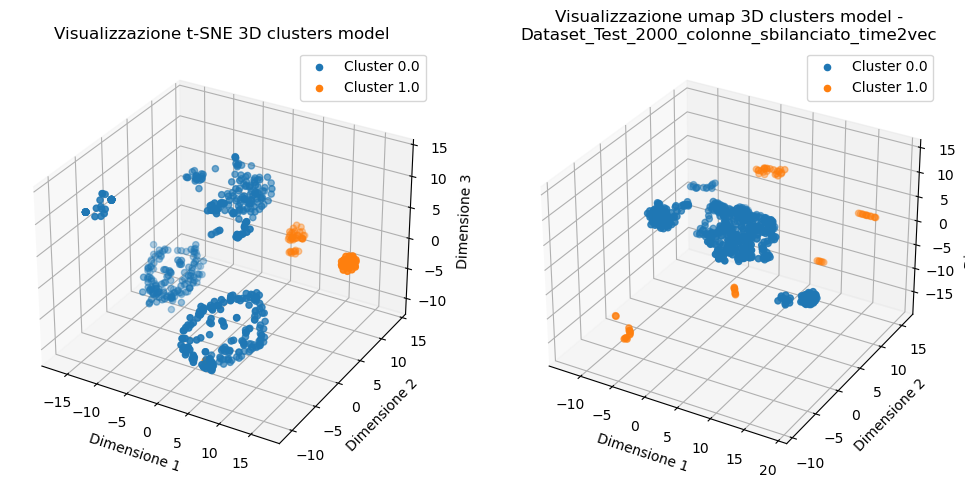

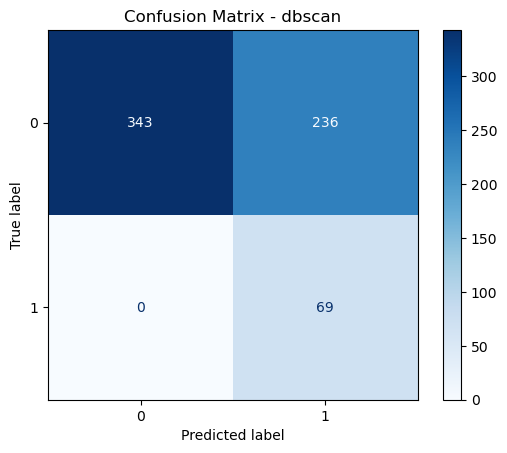

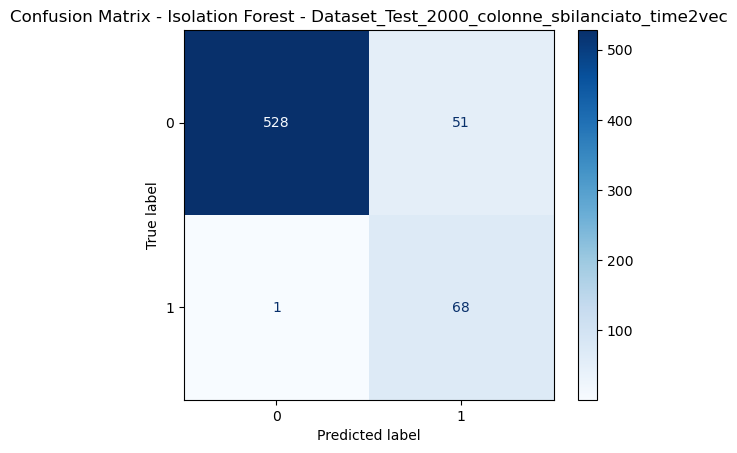

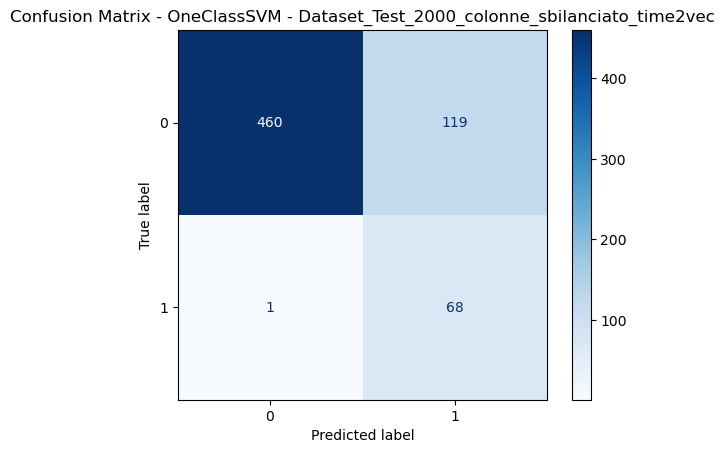

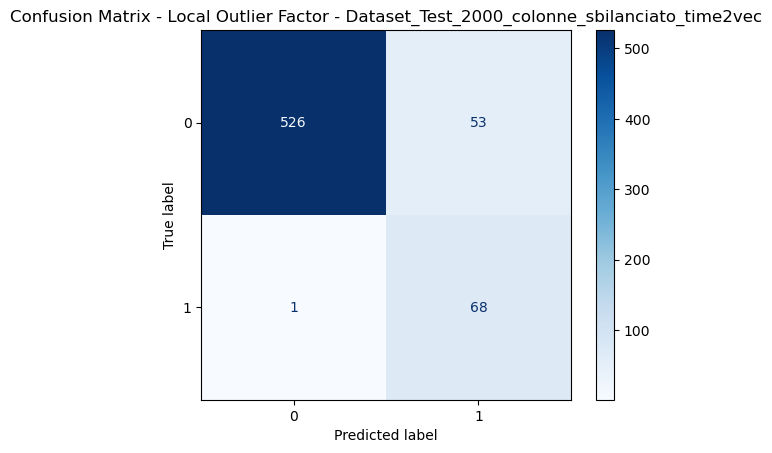

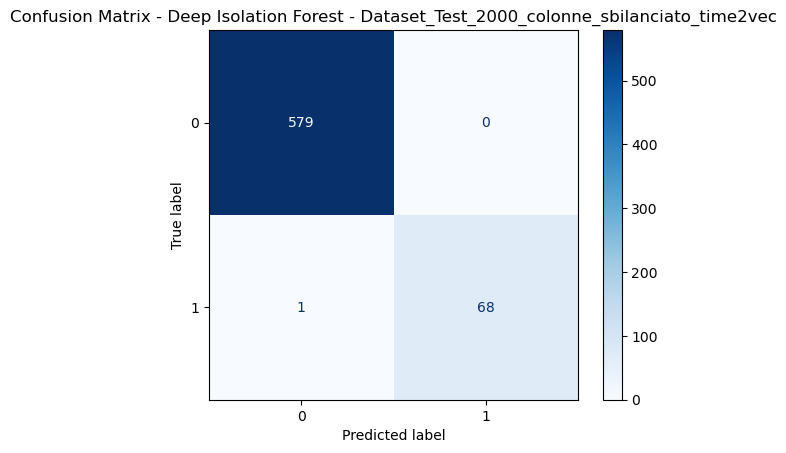

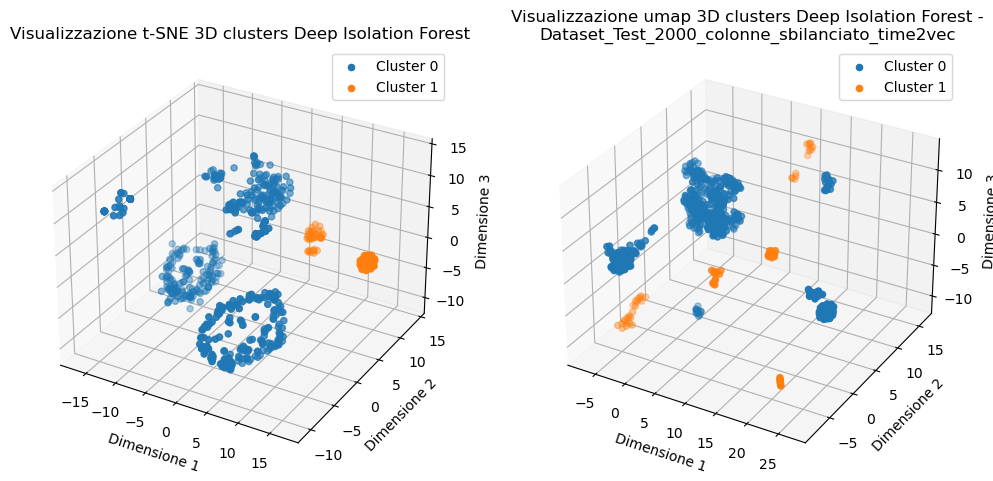

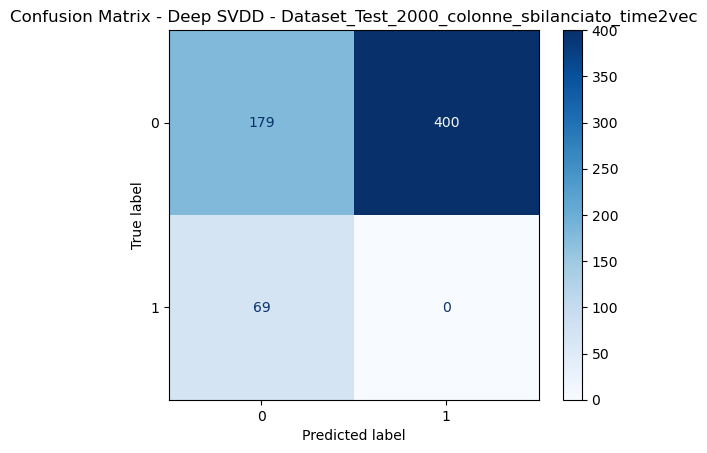

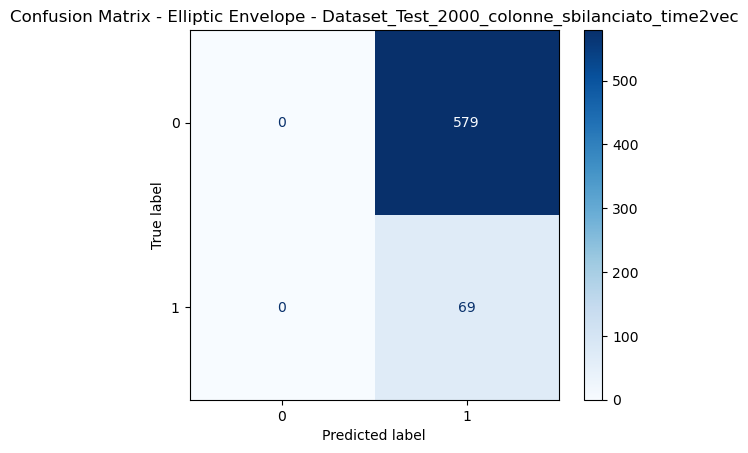

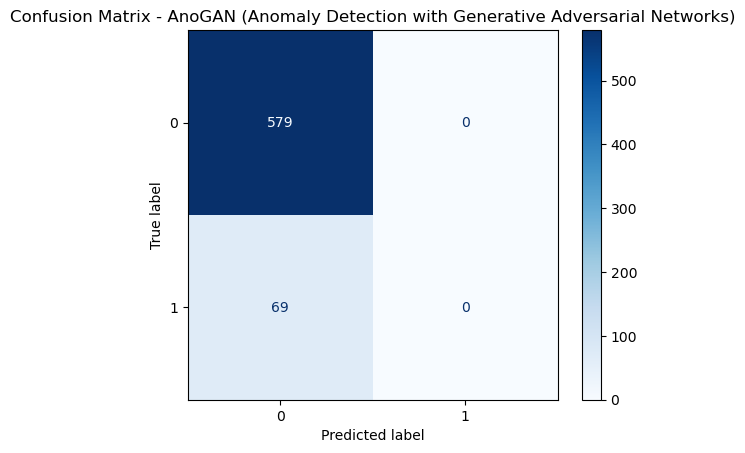

# **Dataset Test 1 Sbilanciato 180 time steps encoder tabular**


In [ ]:
Varianza totale dei dati originali: 1440.0
distanza stimata per ottimizzare il clustering: 33.057

Model: dbscan
Identificati 2 clusters
Silhouette Score: 0.177
F1-Score 0.334
Precision 0.796
Recall 0.319
Stimati noise points: 225
Stimati noise points: 30

Model: Isolation Forest
Identificati 2 clusters
Silhouette Score: 0.175
F1-Score 0.854
Precision 0.882
Recall 0.840
Stimati noise points: 26

Model: OneClassSVM
Silhouette Score: 0.214
F1-Score 0.945
Precision 0.957
Recall 0.941
Stimati noise points: 2099
Stimati noise points: 86

Model: Local Outlier Factor
Identificati 2 clusters
Silhouette Score: 0.137
F1-Score 0.894
Precision 0.932
Recall 0.882
Start Training...
Start Inference on the training data...
Start Inference...
Start Inference...
Start Inference...
Stimati noise points: None

Model: Deep Isolation Forest
Identificati 2 clusters
Silhouette Score: 0.338
F1-Score 0.956
Precision 0.957
Recall 0.958
Start Training...
ensemble size: 1
MLPnet(
  (network): Sequential(
    (0): LinearBlock(
      (linear): Linear(in_features=1800, out_features=100, bias=False)
      (act_layer): ReLU()
    )
    (1): LinearBlock(
      (linear): Linear(in_features=100, out_features=50, bias=False)
      (act_layer): ReLU()
    )
    (2): LinearBlock(
      (linear): Linear(in_features=50, out_features=128, bias=False)
      (act_layer): Identity()
    )
  )
)
epoch  1, training loss: 0.383271, time: 0.7s
epoch 10, training loss: 0.004092, time: 0.4s
epoch 20, training loss: 0.002044, time: 0.4s
epoch 30, training loss: 0.001756, time: 0.4s
epoch 40, training loss: 0.001892, time: 0.4s
epoch 50, training loss: 0.000617, time: 0.4s
epoch 60, training loss: 0.000606, time: 0.5s
epoch 70, training loss: 0.000541, time: 0.8s
epoch 80, training loss: 0.000320, time: 0.4s
epoch 90, training loss: 0.000463, time: 0.4s
epoch100, training loss: 0.000358, time: 0.4s
Start Inference on the training data...
Stimati noise points: 2024
Stimati noise points: 53

Model: Deep SVDD
Identificati 2 clusters
Silhouette Score: 0.078
F1-Score 0.476
Precision 0.598
Recall 0.395
Stimati noise points: 2249
Stimati noise points: 119

Model: Elliptic Envelope
F1-Score 0.044
Precision 0.025
Recall 0.160

AnoGAN Training
Epoch 0 | Discriminator Loss: 21.729829788208008 | Generator Loss: 14.346242904663086
Epoch 100 | Discriminator Loss: 6.51648473739624 | Generator Loss: 5.211211204528809
Epoch 200 | Discriminator Loss: 6.1888651847839355 | Generator Loss: 3.5100183486938477
Epoch 300 | Discriminator Loss: 5.753732204437256 | Generator Loss: 5.192647457122803
Epoch 400 | Discriminator Loss: 6.078673362731934 | Generator Loss: 4.89694356918335
Epoch 500 | Discriminator Loss: 5.886968612670898 | Generator Loss: 4.4327392578125

Model: AnoGAN (Anomaly Detection with Generative Adversarial Networks)
Identificati 2 clusters
Silhouette Score: 0.653
F1-Score: 1.000
Precision: 1.000
Recall: 1.000
AUC PR: 1.000


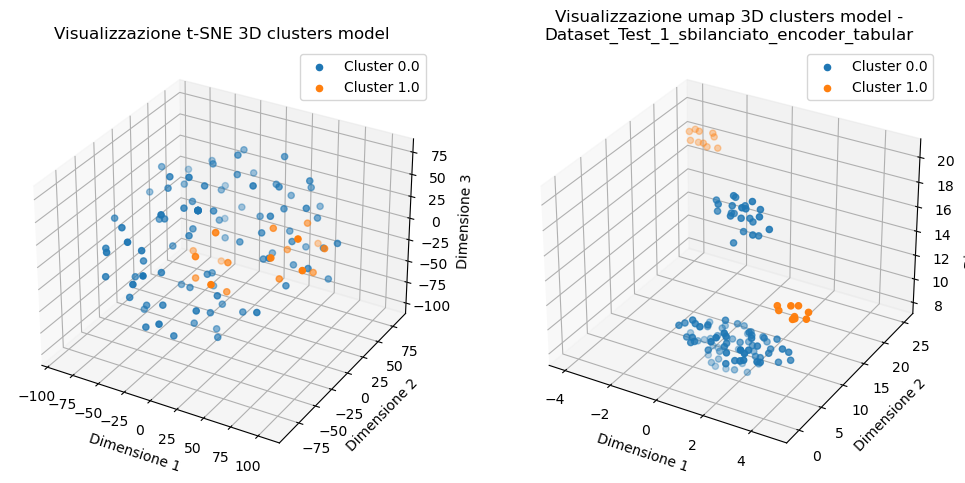

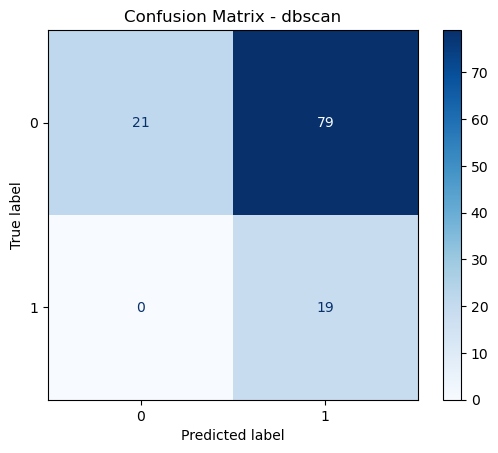

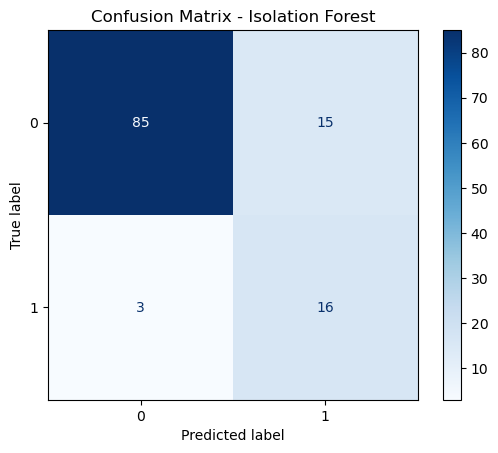

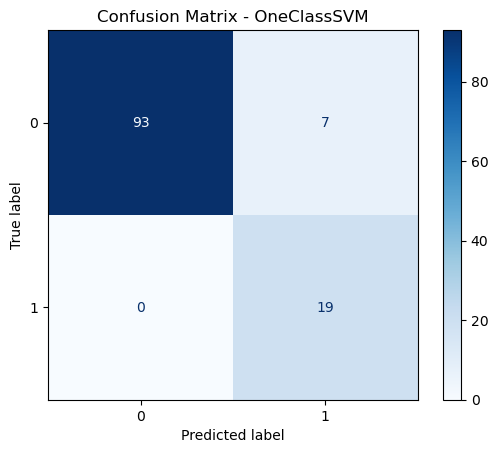

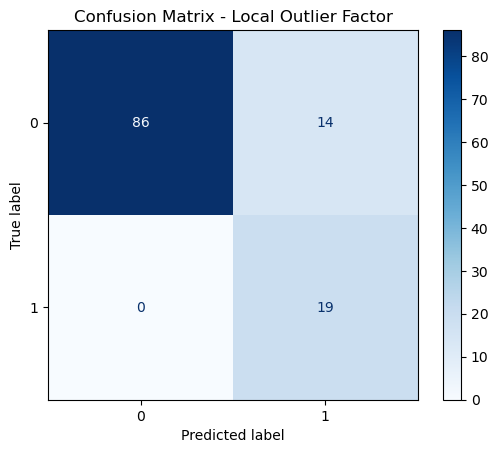

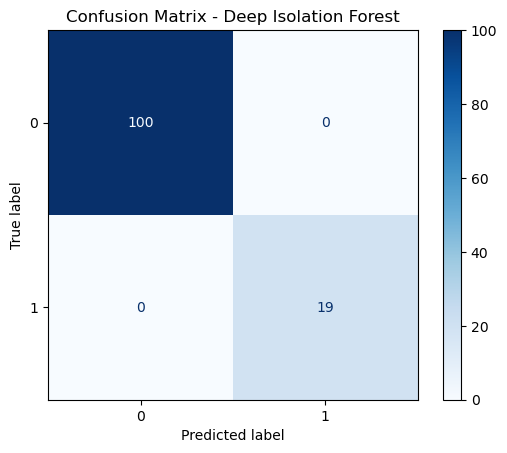

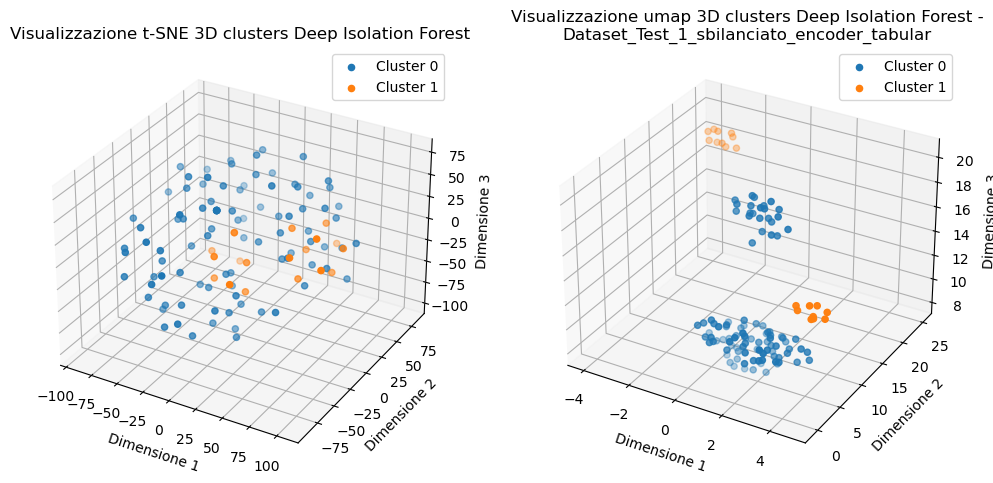

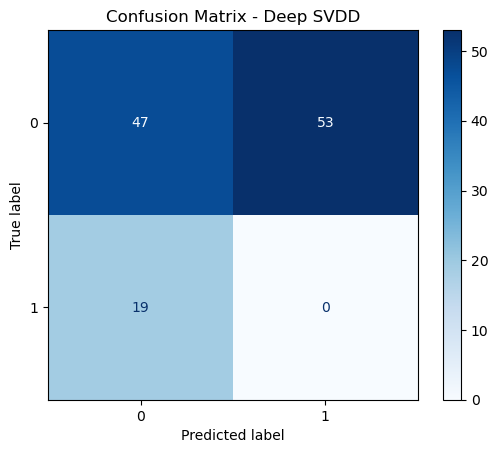

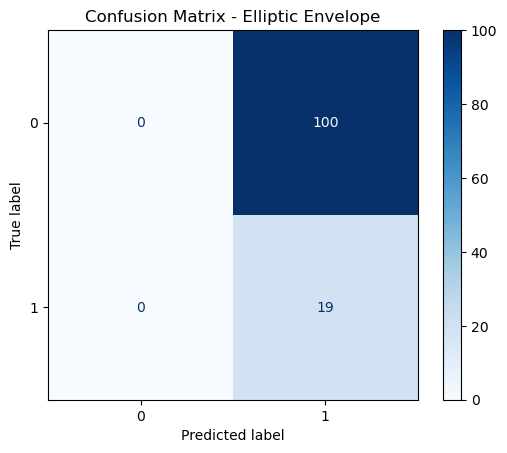

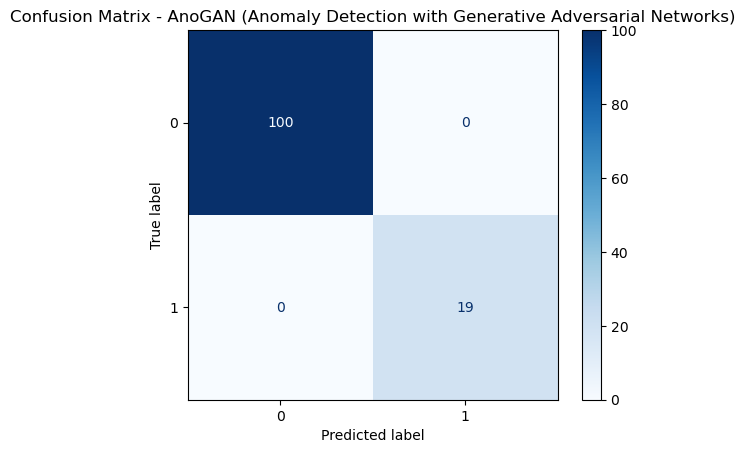

# **Dataset_Test_2_sbilanciato_encoder_tabular**

In [ ]:
Varianza totale dei dati originali: 1440.0
distanza stimata per ottimizzare il clustering: 33.057

Model: dbscan
Identificati 2 clusters
Silhouette Score: 0.177
F1-Score 0.334
Precision 0.796
Recall 0.319
Stimati noise points: 225
Stimati noise points: 30

Model: Isolation Forest
Identificati 2 clusters
Silhouette Score: 0.175
F1-Score 0.854
Precision 0.882
Recall 0.840
Stimati noise points: 26

Model: OneClassSVM
Silhouette Score: 0.214
F1-Score 0.945
Precision 0.957
Recall 0.941
Stimati noise points: 2099
Stimati noise points: 86

Model: Local Outlier Factor
Identificati 2 clusters
Silhouette Score: 0.137
F1-Score 0.894
Precision 0.932
Recall 0.882
Start Training...
Start Inference on the training data...
Start Inference...
Start Inference...
Start Inference...
Stimati noise points: None

Model: Deep Isolation Forest
Identificati 2 clusters
Silhouette Score: 0.338
F1-Score 0.956
Precision 0.957
Recall 0.958
Start Training...
ensemble size: 1
MLPnet(
  (network): Sequential(
    (0): LinearBlock(
      (linear): Linear(in_features=1800, out_features=100, bias=False)
      (act_layer): ReLU()
    )
    (1): LinearBlock(
      (linear): Linear(in_features=100, out_features=50, bias=False)
      (act_layer): ReLU()
    )
    (2): LinearBlock(
      (linear): Linear(in_features=50, out_features=128, bias=False)
      (act_layer): Identity()
    )
  )
)
epoch  1, training loss: 0.383271, time: 0.6s
epoch 10, training loss: 0.004092, time: 0.4s
epoch 20, training loss: 0.002044, time: 0.4s
epoch 30, training loss: 0.001756, time: 0.4s
epoch 40, training loss: 0.001892, time: 0.4s
epoch 50, training loss: 0.000617, time: 0.4s
epoch 60, training loss: 0.000606, time: 0.4s
epoch 70, training loss: 0.000541, time: 0.4s
epoch 80, training loss: 0.000320, time: 0.4s
epoch 90, training loss: 0.000463, time: 0.5s
epoch100, training loss: 0.000358, time: 0.4s
Start Inference on the training data...
Stimati noise points: 2024
Stimati noise points: 53

Model: Deep SVDD
Identificati 2 clusters
Silhouette Score: 0.078
F1-Score 0.476
Precision 0.598
Recall 0.395
Stimati noise points: 2249
Stimati noise points: 119

Model: Elliptic Envelope
F1-Score 0.044
Precision 0.025
Recall 0.160

AnoGAN Training
Epoch 0 | Discriminator Loss: 18.448528289794922 | Generator Loss: 12.824506759643555
Epoch 100 | Discriminator Loss: 8.453293800354004 | Generator Loss: 6.557188510894775
Epoch 200 | Discriminator Loss: 6.549960136413574 | Generator Loss: 3.229050636291504
Epoch 300 | Discriminator Loss: 6.440791130065918 | Generator Loss: 4.908787727355957
Epoch 400 | Discriminator Loss: 6.398231506347656 | Generator Loss: 4.827441215515137
Epoch 500 | Discriminator Loss: 6.390364646911621 | Generator Loss: 4.612576007843018

Model: AnoGAN (Anomaly Detection with Generative Adversarial Networks)
Identificati 2 clusters
Silhouette Score: 0.334
F1-Score: 0.629
Precision: 0.834
Recall: 0.600
AUC PR: 0.568


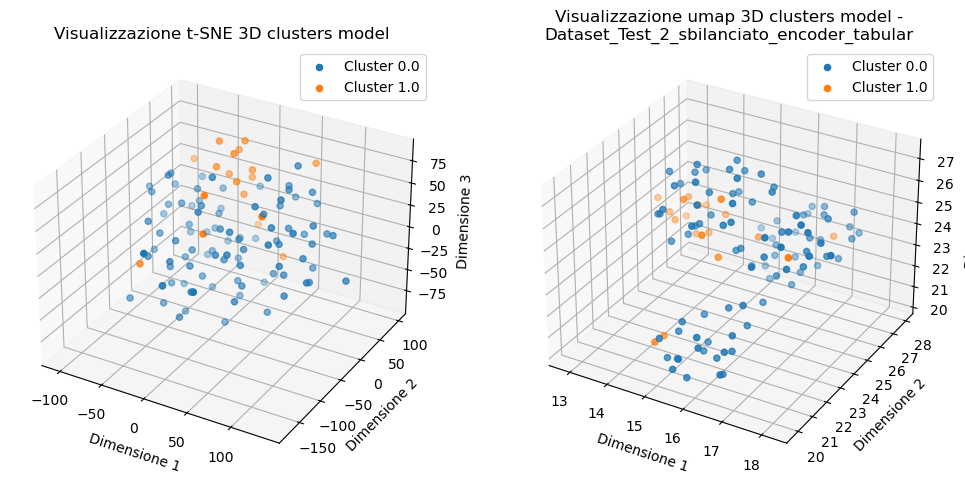

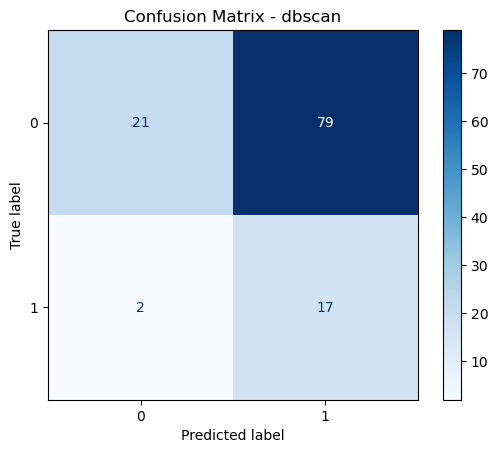

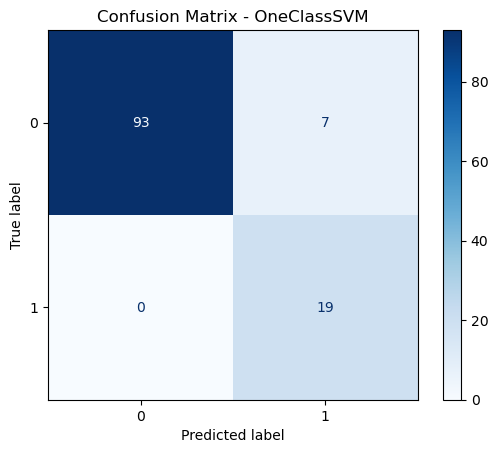

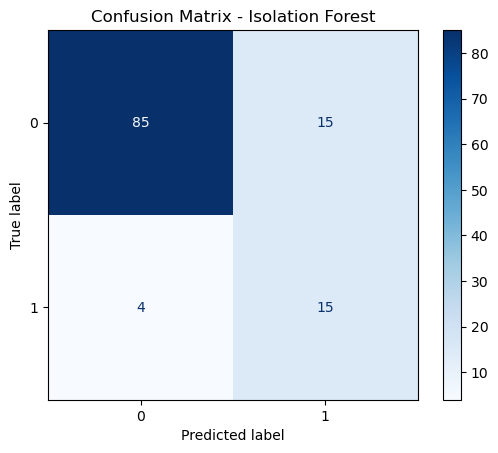

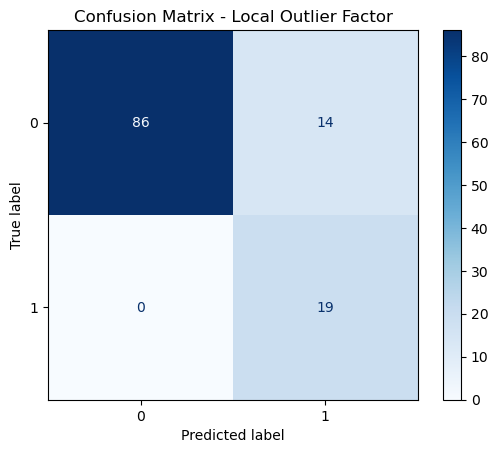

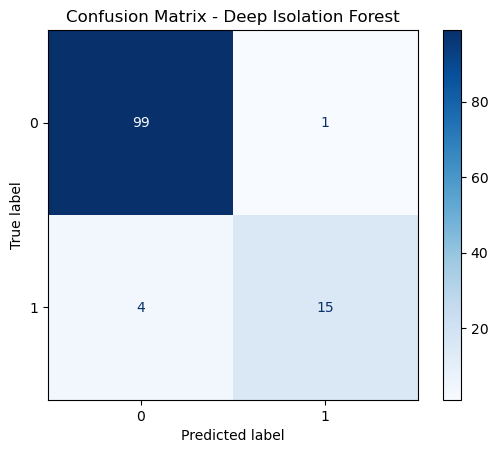

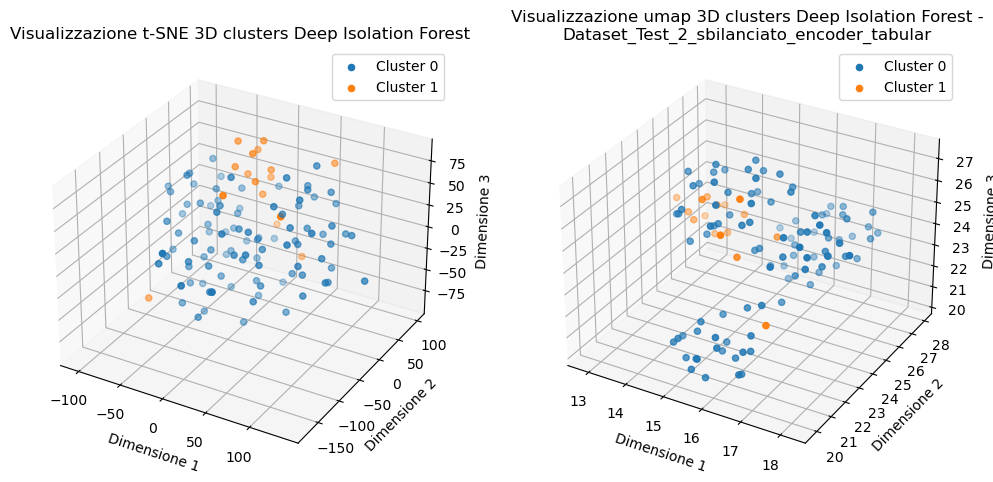

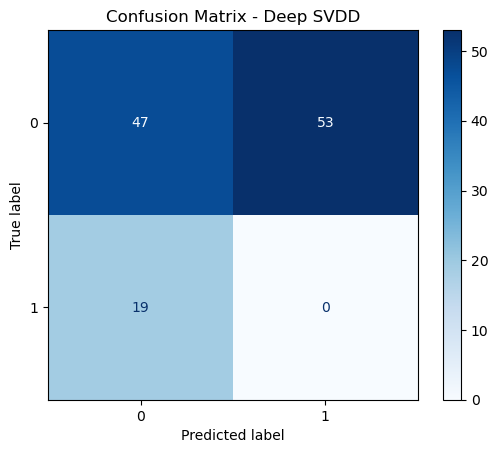

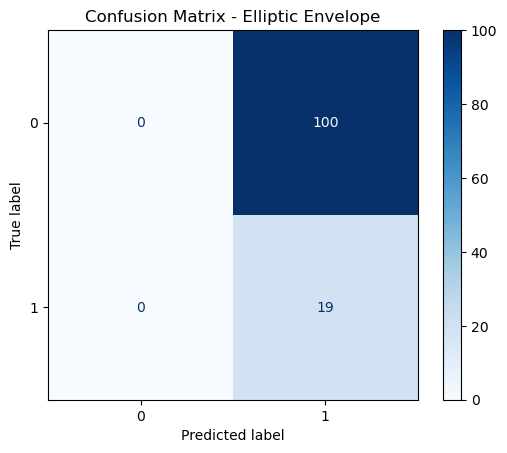

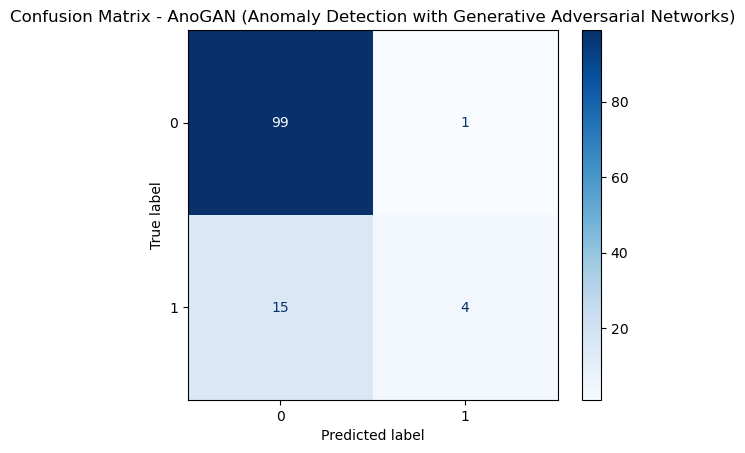